In [1]:
import shutil
import os
import pathlib
import numpy as np
import pandas as pd
import plotly.express as px
import kaggle
import datetime
import tensorflow as tf
import xml.etree.ElementTree as ET

from functools import partial

2025-02-02 09:40:06.320433: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-02 09:40:06.487897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738510806.539673    4600 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738510806.553812    4600 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-02 09:40:06.696192: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Implmentation Outline
- Do pretraining for image classification to learn features
- Convert model to object detection
- Make custom loss function
- Get object detection dataset
- Train according to paper specifications
- Test model

## Pretraining

For pretraining I will use a smaller version of the ImageNet dataset then the one used in the paper.

In [2]:
## Load pretraining data
kaggle.api.authenticate()
# kaggle.api.dataset_download_files('ifigotin/imagenetmini-1000',
#                                 path='/home/misha/Desktop/data/yolo_paper/pretrain_data/image_data/',
#                                 unzip=True)

### Data Preprocessing

In [3]:
PRETRAIN_DATA_PATH = '/home/misha/Desktop/data/yolo_paper/pretrain_data/'
labels_txt = PRETRAIN_DATA_PATH + 'words.txt'

In [4]:
labels = pd.read_csv(labels_txt, sep='\t')

In [5]:
labels

,code,object
0,n00001740,entity
1,n00001930,physical entity
2,n00002137,"abstraction, abstract entity"
3,n00002452,thing
4,n00002684,"object, physical object"
...,...,...
82110,n15299225,study hall
82111,n15299367,"Transfiguration, Transfiguration Day, August 6"
82112,n15299585,usance
82113,n15299783,window


In [6]:
# labels[labels['code'] == 'n03485794214']['object'].values[0]

In [7]:
n_classes = len(os.listdir(PRETRAIN_DATA_PATH + 'image_data/imagenet-mini/train/'))

In [8]:
n_classes

999

In [9]:
len(os.listdir(PRETRAIN_DATA_PATH + 'image_data/imagenet-mini/val/'))

999

In [10]:
os.listdir(PRETRAIN_DATA_PATH + 'image_data/imagenet-mini/val/') == os.listdir(PRETRAIN_DATA_PATH + 'image_data/imagenet-mini/train/')

True

In [11]:
os.listdir(PRETRAIN_DATA_PATH + 'image_data/imagenet-mini/')

['val', 'train']

#### Rename the folders to their label instead of the code

In [12]:
# for split in os.listdir(PRETRAIN_DATA_PATH + 'image_data/imagenet-mini/'):
#     for folder in os.listdir(PRETRAIN_DATA_PATH + 'image_data/imagenet-mini/' + split):
#         try:
#             label = labels[labels['code'] == folder]['object'].values[0]
#         except IndexError as err:
#             print(f"No label found for Split: {split} Folder: {folder}")
#             continue

#         ## Rename folder
#         source_path = PRETRAIN_DATA_PATH + f'image_data/imagenet-mini/{split}/{folder}'
#         destination_path = PRETRAIN_DATA_PATH + f'image_data/imagenet-mini/{split}/{label}'

#         try:
#             shutil.move(source_path, destination_path)
#         except OSError as err:
#             print(f"Error moving folder({folder}): {err}")

In [13]:
os.listdir(PRETRAIN_DATA_PATH + 'image_data/imagenet-mini/val/') == os.listdir(PRETRAIN_DATA_PATH + 'image_data/imagenet-mini/train/')

True

#### Move load data into Tensorflow datasets.

In [14]:
train_dir = pathlib.Path(PRETRAIN_DATA_PATH + 'image_data/imagenet-mini/train/')
val_dir = pathlib.Path(PRETRAIN_DATA_PATH + 'image_data/imagenet-mini/val/')

In [15]:
train_df = tf.keras.utils.image_dataset_from_directory(
    train_dir, 
    labels='inferred',
    color_mode='rgb',
    batch_size=24, 
    label_mode='categorical',   ## Vector Representation (Use categorical_crossentropy loss)
    image_size=(448, 448),
    crop_to_aspect_ratio=True,
    seed=1, 
    shuffle=True
)
val_df = tf.keras.utils.image_dataset_from_directory(
    val_dir, 
    labels='inferred',
    color_mode='rgb',
    batch_size=32, 
    label_mode='categorical',   ## Vector Representation (Use categorical_crossentropy loss)
    image_size=(448, 448),
    crop_to_aspect_ratio=True,
    seed=1, 
    shuffle=True
)

Found 34745 files belonging to 999 classes.


I0000 00:00:1738443045.636493    4488 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9675 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 3923 files belonging to 999 classes.


#### Data augmentation

In [16]:
# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip('horizontal', seed=1),
#     tf.keras.layers.RandomRotation(0.2, seed=1)
# ])

In [17]:
# train_aug = train_df.map(lambda x, y: (data_augmentation(x), y))
# val_aug = val_df.map(lambda x, y: (data_augmentation(x), y))

In [18]:
# train_df = train_df.concatenate(train_aug).prefetch(1)
# val_df = val_df.concatenate(val_aug).prefetch(1)

In [19]:
# len(train_df) * 32

In [20]:
# len(val_df) * 32

### Pretraining

In [21]:
## Partial layers
# Conv2DLayer = partial(tf.keras.layers.Conv2D, strides=(1,1), padding='same',
#                       kernel_initializer='he_normal')
# MaxPoolLayer = partial(tf.keras.layers.MaxPool2D, pool_size=(2,2), strides=2, padding='same',)

In [22]:
# pretraining_model = tf.keras.Sequential()

# # Input layer (only for pretraining, will be removed when applied to full model)
# pretraining_model.add(tf.keras.layers.InputLayer(shape=(224,224,3)))

# ## First 20 layers according to paper
# pretraining_model.add(Conv2DLayer(filters=64, strides=(2,2), kernel_size=(7,7)))
# pretraining_model.add(MaxPoolLayer())
# pretraining_model.add(tf.keras.layers.BatchNormalization())

# pretraining_model.add(Conv2DLayer(filters=192, kernel_size=(3,3)))
# pretraining_model.add(MaxPoolLayer())
# pretraining_model.add(tf.keras.layers.BatchNormalization())

# pretraining_model.add(Conv2DLayer(filters=128, kernel_size=(1,1)))
# pretraining_model.add(Conv2DLayer(filters=256, kernel_size=(3,3)))
# pretraining_model.add(Conv2DLayer(filters=256, kernel_size=(1,1)))
# pretraining_model.add(Conv2DLayer(filters=512, kernel_size=(3,3)))
# pretraining_model.add(MaxPoolLayer())
# pretraining_model.add(tf.keras.layers.BatchNormalization())

# for _ in range(4):
#     pretraining_model.add(Conv2DLayer(filters=256, kernel_size=(1,1)))
#     pretraining_model.add(Conv2DLayer(filters=512, kernel_size=(3,3)))
#     pretraining_model.add(tf.keras.layers.BatchNormalization())
# pretraining_model.add(Conv2DLayer(filters=512, kernel_size=(1,1)))
# pretraining_model.add(Conv2DLayer(filters=1024, kernel_size=(3,3)))
# pretraining_model.add(MaxPoolLayer())
# pretraining_model.add(tf.keras.layers.BatchNormalization())

# ## Flatten Layer
# pretraining_model.add(tf.keras.layers.Flatten())
# pretraining_model.add(tf.keras.layers.BatchNormalization())

# ## Output layer for pretraining (will be removed when layers are reused)
# pretraining_model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

In [23]:
# pretraining_model.summary()

In [24]:
## Loaded model from checkpoint
# pretraining_model = tf.keras.models.load_model('best_pretrain_model.keras')

In [25]:
## Pretraining
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9, nesterov=True)
# pretraining_model.compile(optimizer=optimizer,
#                           loss=tf.keras.losses.categorical_crossentropy,
#                           metrics=['accuracy'])

In [26]:
# checkpoints = tf.keras.callbacks.ModelCheckpoint('best_pretrain_model.keras', monitor='val_accuracy',
#                                                  verbose=1, save_best_only=True)
# tb_dir = 'logs/yolo/pretrain/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir)

# pretraining_model.fit(train_df, validation_data=val_df, epochs=25, 
#                      callbacks=[checkpoints, tensorboard_callback])

## Using transfer learning for pretraining

In order to save time I will just do transfer learning for this pretraining since it shouldn't affect the actual model a lot.

We will use EfficientNetV2M

### Model fine tune

In [17]:
preprocess_func = tf.keras.applications.efficientnet_v2.preprocess_input

train_df = train_df.map(lambda X, y: (preprocess_func(X), y)).prefetch(2)
val_df = val_df.map(lambda X, y: (preprocess_func(X), y)).prefetch(2)

In [16]:
base_pretrain_model = tf.keras.applications.efficientnet_v2.EfficientNetV2M(weights='imagenet', 
                                                                           include_top=False,
                                                                           input_shape=(448, 448, 3))
avg = tf.keras.layers.GlobalAveragePooling2D()(base_pretrain_model.output)
output = tf.keras.layers.Dense(n_classes, activation='softmax')(avg)
model = tf.keras.Model(inputs=base_pretrain_model.input, outputs=output)

In [19]:
model = tf.keras.models.load_model('pretrain_model.keras')

In [20]:
len(model.layers)

742

In [21]:
for layer in base_pretrain_model.layers[:-2]:
    layer.trainable = False

In [19]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='pretrain_model.keras', monitor='val_accuracy', verbose=1,
                                               save_best_only=True)

optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(train_df, validation_data=val_df, epochs=4,
                   callbacks=[checkpoint])

Epoch 1/4


I0000 00:00:1737939791.963067    4417 service.cc:148] XLA service 0x70134c0e2070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737939791.963556    4417 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-01-26 19:03:12.722268: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737939794.986615    4417 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-26 19:03:18.906821: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33313', 468 bytes spill stores, 312 bytes spill loads

2025-01-26 19:03:19.085889: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33313', 560 

1447/1448 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6516 - loss: 3.3073  

2025-01-26 19:09:06.674323: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33313', 468 bytes spill stores, 312 bytes spill loads

2025-01-26 19:09:06.827460: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33313', 560 bytes spill stores, 504 bytes spill loads

2025-01-26 19:09:06.948794: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33584', 368 bytes spill stores, 368 bytes spill loads

2025-01-26 19:09:07.249976: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33313', 608 bytes spill stores, 556 bytes spill loads

2025-01-26 19:09:07.580229: I external/local_xla

1448/1448 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.6517 - loss: 3.3061

2025-01-26 19:09:32.280200: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6082', 324 bytes spill stores, 320 bytes spill loads

2025-01-26 19:09:32.386512: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6082', 4 bytes spill stores, 4 bytes spill loads

2025-01-26 19:09:32.389803: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6082', 400 bytes spill stores, 400 bytes spill loads

2025-01-26 19:09:32.630126: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6082_0', 340 bytes spill stores, 340 bytes spill loads

2025-01-26 19:09:32.650359: I external/local_xla/xla/s


Epoch 1: val_accuracy improved from -inf to 0.83151, saving model to pretrain_model.keras
1448/1448 ━━━━━━━━━━━━━━━━━━━━ 459s 286ms/step - accuracy: 0.6518 - loss: 3.3049 - val_accuracy: 0.8315 - val_loss: 0.6980
Epoch 2/4
1448/1448 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9293 - loss: 0.2610  
Epoch 2: val_accuracy improved from 0.83151 to 0.83329, saving model to pretrain_model.keras
1448/1448 ━━━━━━━━━━━━━━━━━━━━ 355s 245ms/step - accuracy: 0.9293 - loss: 0.2610 - val_accuracy: 0.8333 - val_loss: 0.7166
Epoch 3/4
  35/1448 ━━━━━━━━━━━━━━━━━━━━ 5:09 219ms/step - accuracy: 0.9351 - loss: 0.2108

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(history.history).plot()

In [22]:
len(base_pretrain_model.layers)

740

In [23]:
## Unfreeze some layers and retrain
for layer in model.layers[:75]:
    layer.trainable = True

In [25]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=2)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='pretrain_model.keras', monitor='val_accuracy', verbose=1,
                                               save_best_only=True)

history = model.fit(train_df, validation_data=val_df, epochs=10, 
                    callbacks=[early_stop, checkpoint])

Epoch 1/10


I0000 00:00:1737995271.312966    4282 service.cc:148] XLA service 0x79a544001fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737995271.313113    4282 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-01-27 10:27:52.235679: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737995274.951479    4282 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-27 10:27:59.833675: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37262', 468 bytes spill stores, 312 bytes spill loads

2025-01-27 10:27:59.990516: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37262', 560 

1447/1448 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.9119 - loss: 0.3068   

2025-01-27 10:42:34.261030: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37262', 468 bytes spill stores, 312 bytes spill loads

2025-01-27 10:42:34.455139: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37262', 560 bytes spill stores, 504 bytes spill loads

2025-01-27 10:42:34.520599: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37518', 636 bytes spill stores, 480 bytes spill loads

2025-01-27 10:42:35.045323: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37262', 608 bytes spill stores, 556 bytes spill loads

2025-01-27 10:42:35.423799: I external/local_xla

1448/1448 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.9119 - loss: 0.3068

2025-01-27 10:43:17.336899: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6082', 324 bytes spill stores, 320 bytes spill loads

2025-01-27 10:43:17.577251: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6082', 4176 bytes spill stores, 4048 bytes spill loads

2025-01-27 10:43:17.583584: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6082_0', 340 bytes spill stores, 340 bytes spill loads

2025-01-27 10:43:17.653871: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6082', 400 bytes spill stores, 400 bytes spill loads

2025-01-27 10:43:17.654189: I external/local_xla


Epoch 1: val_accuracy improved from -inf to 0.80729, saving model to pretrain_model.keras
1448/1448 ━━━━━━━━━━━━━━━━━━━━ 1013s 654ms/step - accuracy: 0.9119 - loss: 0.3068 - val_accuracy: 0.8073 - val_loss: 0.8846
Epoch 2/10
1448/1448 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.9289 - loss: 0.2252   
Epoch 2: val_accuracy did not improve from 0.80729
1448/1448 ━━━━━━━━━━━━━━━━━━━━ 856s 591ms/step - accuracy: 0.9290 - loss: 0.2252 - val_accuracy: 0.8042 - val_loss: 0.9304
Epoch 3/10
1448/1448 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.9411 - loss: 0.1791   
Epoch 3: val_accuracy did not improve from 0.80729
1448/1448 ━━━━━━━━━━━━━━━━━━━━ 847s 585ms/step - accuracy: 0.9411 - loss: 0.1791 - val_accuracy: 0.7856 - val_loss: 1.0096


In [4]:
pretrain_model = tf.keras.models.load_model('pretrain_model.keras')

I0000 00:00:1738510813.550000    4600 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9571 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


## YOLO Model

### Outline for building
- Get Dataset Pascal VOC or whatever is said in paper
- Build Model class
- Build loss function
- Figure out infrence
- Train

### Download and Clean Dataset

In [5]:
# kaggle.api.dataset_download_files('gopalbhattrai/pascal-voc-2012-dataset',
#                                  path='/home/misha/Desktop/data/yolo_paper/train_data',
#                                  unzip=True)

In [6]:
def get_center_coords(bbox):
    xmin, ymin, xmax, ymax = bbox
    center_x = (xmin + xmax) / 2
    center_y = (ymin + ymax) / 2
    return center_x, center_y

In [7]:
# Create the label map
label_map = {
    "aeroplane": 0,
    "bicycle": 1,
    "bird": 2,
    "boat": 3,
    "bottle": 4,
    "bus": 5,
    "car": 6,
    "cat": 7,
    "chair": 8,
    "cow": 9,
    "diningtable": 10,
    "dog": 11,
    "horse": 12,
    "motorbike": 13,
    "person": 14,
    "pottedplant": 15,
    "sheep": 16,
    "sofa": 17,
    "train": 18,
    "tvmonitor": 19
}

In [75]:
def pascal_voc_generator(image_dir, annotation_dir, image_set_file):
    image_dir = str(image_dir)
    annotation_dir = str(annotation_dir)
    
    with open(image_set_file, 'r') as f:
        ## Get list of image ids for the split
        image_ids = [line.strip() for line in f]
    for image_id in image_ids:
        image_id = str(image_id)
        
        ## For each id, get corresponding image and annotation file
        image_path = str(os.path.join(image_dir, f"{image_id}.jpg")).replace('b\'', '').replace('\'', '')
        annotation_path = str(os.path.join(annotation_dir, f"{image_id}.xml")).replace('b\'', '').replace('\'', '')

        ## Ensure the paths are strings and normalized
        image_path = os.path.normpath(image_path)
        annotation_path = os.path.normpath(annotation_path)
        
        ## Load the image
        try:

            if not os.path.exists(image_path):
                print(f"Image file not found: {image_path}")
                continue
        
            if not os.path.exists(annotation_path):
                print(f"Annotation file not found: {annotation_path}")
                continue
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(448,448), keep_aspect_ratio=True)
            image = tf.keras.preprocessing.image.img_to_array(image)
            image = image / 255.0 ## Normalize
            
            ## Parse the XML file
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            bboxes = []
            labels = []
            for obj in root.findall('object'):
                bbox = obj.find('bndbox')
                xmin = int(bbox.find('xmin').text)
                ymin = int(bbox.find('ymin').text)
                xmax = int(bbox.find('xmax').text)
                ymax = int(bbox.find('ymax').text)
    
                ## Get actual features
                center_x, center_y = get_center_coords([xmin, ymin, xmax, ymax])
                # Calculate width and height
                width = xmax - xmin
                height = ymax - ymin
    
                ## Convert label to numeric value
                label_name = obj.find('name').text.lower()
                label = label_map[label_name]
                
                bboxes.append([center_x, center_y, width, height])
                labels.append(label)
    
            yield image, bboxes, labels
        except Exception as err:
            print(f'''Error ocurred:
                Image id: {image_id}
                Error Message: {err}
            ''')


In [76]:
image_dir = '/home/misha/Desktop/data/yolo_paper/train_data/VOC2012_train_val/VOC2012_train_val/JPEGImages'
annotation_dir = '/home/misha/Desktop/data/yolo_paper/train_data/VOC2012_train_val/VOC2012_train_val/Annotations'
image_set_file = '/home/misha/Desktop/data/yolo_paper/train_data/VOC2012_train_val/VOC2012_train_val/ImageSets/Main/train.txt'

train_df = tf.data.Dataset.from_generator(
    pascal_voc_generator,
    args=(image_dir, annotation_dir, image_set_file),
    output_signature=(
        tf.TensorSpec(shape=(448, 448, 3), dtype=tf.float32), # Image Shape
        tf.TensorSpec(shape=(None, 4), dtype=tf.float32), # Bboxes shape
        tf.TensorSpec(shape=(None,), dtype=tf.int32) # Label shape
    )
)


## Val DF now
image_dir = '/home/misha/Desktop/data/yolo_paper/train_data/VOC2012_train_val/VOC2012_train_val/JPEGImages'
annotation_dir = '/home/misha/Desktop/data/yolo_paper/train_data/VOC2012_train_val/VOC2012_train_val/Annotations'
image_set_file = '/home/misha/Desktop/data/yolo_paper/train_data/VOC2012_train_val/VOC2012_train_val/ImageSets/Main/val.txt'

val_df = tf.data.Dataset.from_generator(
    pascal_voc_generator,
    args=(image_dir, annotation_dir, image_set_file),
    output_signature=(
        tf.TensorSpec(shape=(448, 448, 3), dtype=tf.float32), # Image Shape
        tf.TensorSpec(shape=(None, 4), dtype=tf.float32), # Bboxes shape
        tf.TensorSpec(shape=(None,), dtype=tf.int32) # Label shape
    )
)

## Test DF
image_dir = '/home/misha/Desktop/data/yolo_paper/train_data/VOC2012_test/VOC2012_test/JPEGImages'
annotation_dir = '/home/misha/Desktop/data/yolo_paper/train_data/VOC2012_test/VOC2012_test/Annotations'
image_set_file = '/home/misha/Desktop/data/yolo_paper/train_data/VOC2012_test/VOC2012_test/ImageSets/Main/test.txt'

test_df = tf.data.Dataset.from_generator(
    pascal_voc_generator,
    args=(image_dir, annotation_dir, image_set_file),
    output_signature=(
        tf.TensorSpec(shape=(448, 448, 3), dtype=tf.float32), # Image Shape
        tf.TensorSpec(shape=(None, 4), dtype=tf.float32), # Bboxes shape
        tf.TensorSpec(shape=(None,), dtype=tf.int32) # Label shape
    )
)

In [77]:
train_df = train_df.prefetch(1)
val_df = val_df.prefetch(1)
test_df = test_df.prefetch(1)

In [78]:
def visualize_tf_dataset(dataset, num_instances=1):
    """
    Visualize instances from a TensorFlow dataset with bounding boxes.
    
    Args:
        dataset (tf.data.Dataset): The TensorFlow dataset to visualize.
        num_instances (int, optional): Number of instances to visualize. Defaults to 1.
    """
    # Create class names list based on the global label_map
    class_names = [key for key, _ in sorted(label_map.items(), key=lambda x: x[1])]
    
    # Track the number of instances visualized
    instances_visualized = 0
    
    # Iterate through the dataset
    for image, bboxes, labels in dataset:
        # Convert to numpy
        image_np = image.numpy()
        bboxes_np = bboxes.numpy()
        labels_np = labels.numpy()
        
        # Create a Plotly figure for this instance
        fig = px.imshow(image_np)
        fig.update_layout(
            showlegend=False,
            margin=dict(l=0, r=0, t=0, b=0),
            xaxis=dict(showticklabels=False, showgrid=False),
            yaxis=dict(showticklabels=False, showgrid=False)
        )
        
        # Add bounding boxes
        for bbox, label in zip(bboxes_np, labels_np):
            # Unpack bbox (center_x, center_y, width, height)
            center_x, center_y, width, height = bbox
            
            # Calculate corner coordinates
            xmin = center_x - width / 2
            ymin = center_y - height / 2
            xmax = center_x + width / 2
            ymax = center_y + height / 2
            
            # Add rectangle shape for bounding box
            fig.add_shape(
                type="rect",
                x0=xmin, 
                y0=ymin, 
                x1=xmax, 
                y1=ymax,
                line=dict(color="red", width=2),
                fillcolor="rgba(255,0,0,0.1)"  # Slight red fill for visibility
            )
            
            # Add label annotation
            fig.add_annotation(
                x=center_x,
                y=ymin,  # Place text just above the bounding box
                text=class_names[label],
                showarrow=True,
                arrowhead=1,
                ax=0,
                ay=-40,  # Move the text up
                font=dict(color="red", size=12),
                bordercolor="white",
                borderwidth=2,
                borderpad=4,
                bgcolor="white"
            )
        
        # Show the figure
        fig.show()
        
        # Increment instances and break if we've reached the desired number
        instances_visualized += 1
        if instances_visualized >= num_instances:
            break

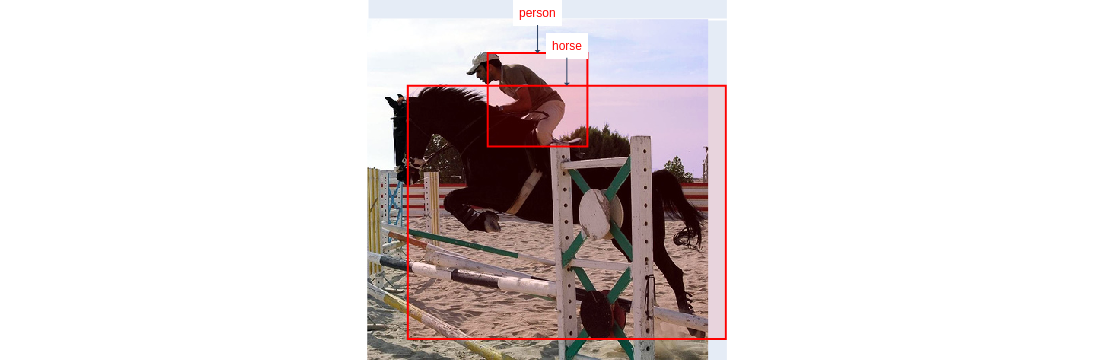

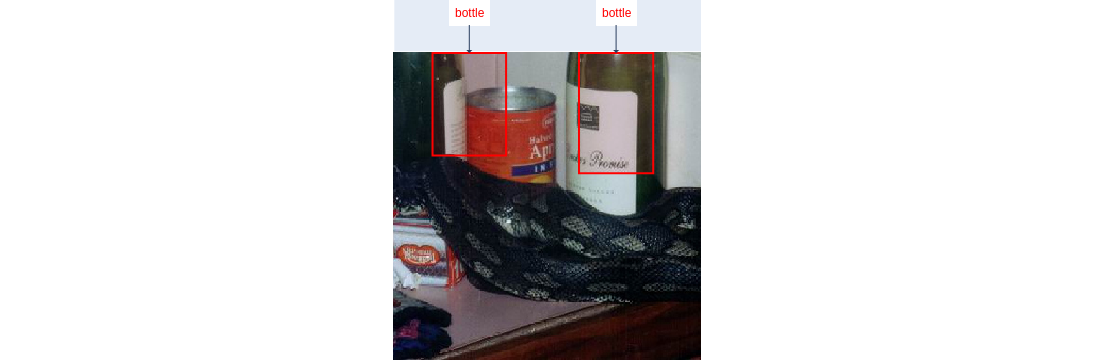

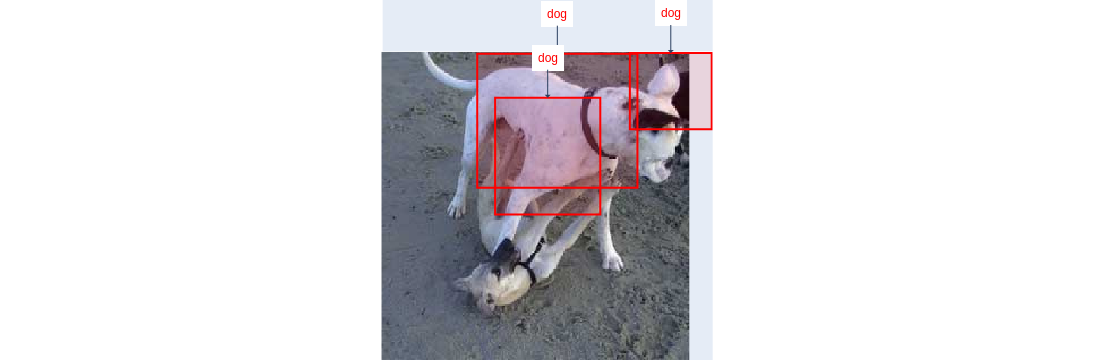

In [79]:
visualize_tf_dataset(train_df, num_instances=3)

In [80]:
train_df = train_df.shuffle(500).batch(32)
val_df = val_df.shuffle(100).batch(32)

There are not supposed to be annotation files for the test set.

In [14]:
def convert_to_yolo_format(bboxes, labels, grid_size=7, num_classes=20):
    """
    Converts bounding boxes and labels to YOLO output format.

    Args:
      bboxes: A list of bounding boxes, each as [center_x, center_y, width, height].
      labels: A list of corresponding class labels.
      grid_size: The size of the YOLO grid (default 7).
      num_classes: The number of classes in the dataset (default 20).

    Returns:
      A NumPy array of shape (1, grid_size, grid_size, 30) representing the YOLO output.
    """

    y_true = np.zeros((1, grid_size, grid_size, 30))

    for bbox, label in zip(bboxes, labels):
        center_x, center_y, width, height = bbox

        # Calculate grid cell indices
        grid_x = min(grid_size - 1, int(center_x * grid_size))
        grid_y = min(grid_size - 1, int(center_y * grid_size))

        # Normalize bounding box coordinates relative to the grid cell
        x = center_x * grid_size - grid_x
        y = center_y * grid_size - grid_y
        w = width
        h = height

        # Set bounding box values in y_true
        y_true[0, grid_y, grid_x, 0:4] = [x, y, w, h]
        y_true[0, grid_y, grid_x, 4] = 1.0  # Confidence score (object present)

        # Set one-hot encoded class probability
        y_true[0, grid_y, grid_x, 10 + label] = 1.0

    return y_true

### Model Class

In [59]:
class YOLOModel(tf.keras.Model):
    """
    Model class for the original YOLO model from the 2016 paper
    """
    def __init__(self, pretrain_model, grid_size=7, boxes_per=2,  ### Defualt for PASCAL VOC Dataset but can be changed
                 classes=20, **kwargs):
        super().__init__(**kwargs)
        
        ### This is the base model used for the feature extraction.
        ### For my case EfficientNetV2 that was fine tuned earlier

        ### Grab the top activation function and ignore the output layers
        ### Used during finetuning
        
        output_layer = pretrain_model.get_layer(name='top_activation')
        self.base_model = tf.keras.Model(
            inputs=pretrain_model.inputs,
            outputs=output_layer.output,
            name='base_model'
        )

        ## Don't allow training on transfered layers
        self.base_model.trainable = False
        
        ### Layers after pretraining 4 Conv & 2 Dense
        Conv2DLayer = partial(tf.keras.layers.Conv2D, kernel_size=(3,3), padding='same', strides=(1,1),
                              kernel_initializer='he_normal', activation=tf.keras.layers.LeakyReLU(negative_slope=0.1))
        self.conv1 = Conv2DLayer(filters=1024)  
        self.conv2 = Conv2DLayer(filters=1024, strides=(2,2))
        self.conv3 = Conv2DLayer(filters=1024)
        self.conv4 = Conv2DLayer(filters=1024)
        self.flatten = tf.keras.layers.Flatten()

        ### Final Fully connected layers
        self.dense1 = tf.keras.layers.Dense(4096, activation=tf.keras.layers.LeakyReLU(negative_slope=0.1),
                                           kernel_initializer='he_normal')
        ### Dropout to avoid overfitting
        self.dropout = tf.keras.layers.Dropout(0.5)
        
        self.output_layer = tf.keras.layers.Dense(units=(grid_size * grid_size * (boxes_per * 5 + classes)), ### Calculate the num of units
                                           activation='linear', kernel_initializer='he_normal')  

    ## Handles the foward pass logic of the model (i.e. how the data flows through)
    def call(self, inputs):
        base_model = self.base_model(inputs)
        conv1 = self.conv1(base_model)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        flatten = self.flatten(conv4)
        dense1 = self.dense1(flatten)
        dropout = self.dropout(dense1)
        output = self.output_layer(dropout)
        output = tf.reshape(output, (-1, 7, 7, 30))  ### Reshape to match YOLO output dimensions
        return output

    ## Customizes the training step (forward pass, loss calc, gradient computation, etc)
    def train_step(self, data):
        images, bboxes, labels = data

        with tf.GradientTape() as tape:
            y_pred = self(images, training=True)

            y_true = convert_to_yolo_format(bboxes, labels)
            
            loss = self.loss_fn(y_true, y_pred) ## Calculate loss using custom loss function

        ## Calculate gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        ## Update weights 
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {'loss': loss}

    ## Customizes the evaluation step on test data:
    #### MAY NOT BE NEEDED ####
    def test_step(self, data):
        pass

In [60]:
## Test forward pass
input_shape = (1, 448, 448, 3)  # Batch size of 1, 448x448 image, 3 color channels
example_input = np.random.rand(*input_shape) 

yolo_model = YOLOModel(pretrain_model) 

output = yolo_model(example_input)

print(output.shape)  # Should print (1, 7, 7, 30)

/home/misha/Desktop/env/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 448, 448, 3))



(1, 7, 7, 30)


In [61]:
yolo_model.summary(show_trainable=True)

Model: "yolo_model_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ base_model (Functional)     │ (None, 14, 14, 1280)  │ 53,150,388 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_12 (Conv2D)          │ (1, 14, 14, 1024)     │ 11,797,504 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_13 (Conv2D)          │ (1, 7, 7, 1024)       │  9,438,208 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_14 (Conv2D)          │ (1, 7, 7, 1024)       │  9,438,208 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_15 (Conv2D)          │ (1, 7, 7, 1024)       │  9,438,208 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_3 (Flatten)         │ (1, 50176)            │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_6 (Dense)             │ (1, 4096)             │ 205,524,9… │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_3 (Dropout)         │ ?                     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_7 (Dense)             │ (1, 1470)             │  6,022,590 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 304,810,098 (1.14 GB)

 Trainable params: 251,659,710 (960.01 MB)

 Non-trainable params: 53,150,388 (202.75 MB)

### Build Loss Function

In [63]:
def calculate_iou(box1, box2):
    """
    Calculates Intersection over Union (IoU) between two bounding boxes.

    Args:
        box1: Tensor of shape (..., 4) representing the first box coordinates (x_center, y_center, width, height).
        box2: Tensor of shape (..., 4) representing the second box coordinates (x_center, y_center, width, height).

    Returns:
        Tensor of shape (...) representing the IoU between the boxes.
    """

    # Calculate the coordinates of the top-left and bottom-right corners of each box
    box1_xmin = box1[..., 0] - box1[..., 2] / 2.0
    box1_ymin = box1[..., 1] - box1[..., 3] / 2.0
    box1_xmax = box1[..., 0] + box1[..., 2] / 2.0
    box1_ymax = box1[..., 1] + box1[..., 3] / 2.0

    box2_xmin = box2[..., 0] - box2[..., 2] / 2.0
    box2_ymin = box2[..., 1] - box2[..., 3] / 2.0
    box2_xmax = box2[..., 0] + box2[..., 2] / 2.0
    box2_ymax = box2[..., 1] + box2[..., 3] / 2.0

    # Find the coordinates of the intersection rectangle
    inter_xmin = tf.maximum(box1_xmin, box2_xmin)
    inter_ymin = tf.maximum(box1_ymin, box2_ymin)
    inter_xmax = tf.minimum(box1_xmax, box2_xmax)
    inter_ymax = tf.minimum(box1_ymax, box2_ymax)

    # Calculate the width and height of the intersection rectangle
    inter_width = tf.maximum(0.0, inter_xmax - inter_xmin)
    inter_height = tf.maximum(0.0, inter_ymax - inter_ymin)

    # Calculate the area of intersection
    intersection_area = inter_width * inter_height

    # Calculate the area of each box
    box1_area = box1[..., 2] * box1[..., 3]
    box2_area = box2[..., 2] * box2[..., 3]

    # Calculate the IoU
    iou = intersection_area / (box1_area + box2_area - intersection_area + 1e-10)  # Add a small epsilon to avoid division by zero

    return iou    

In [64]:
class YOLOLoss(tf.keras.losses.Loss):
    """
    Loss function for YOLO
    Example input for PASCAL VOC: (7,7,30) Tensor where
    (row of grid, column of grid, [1st bounding box(0-4), 2nd bounding box(5-9), 20 classes and their probabalities(10-29)])
    bounding box dimensions: [x-cord, y-cord, width, height, confindence]
    """
    def __init__(self, grid_size=7, boxes_per=2, num_classes=20,
                 threshold=0.6, lambda_coord=5, lambda_noobj=0.5,
                 iou_threshold=0.5, **kwargs):
        super().__init__(**kwargs)
        self.grid_size = 7
        self.boxes_per_cell = boxes_per
        self.num_classes = num_classes
        self.threshold = threshold  ## Confidence threshold
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.iou_threshold = iou_threshold

    def call(self, y_true, y_pred):
        #### First determine if detecting an object in box ####

        ## Calculate IoU for each bounding box
        iou_box1 = calculate_iou(y_true[...,:4], y_pred[...,:4])
        iou_box2 = calculate_iou(y_true[..., 5:9], y_pred[..., 5:9])

        ## Determine responsible bounding box (higher IoU)
        responsible_box_mask = tf.cast(iou_box1 > iou_box2, dtype=tf.float32)

        ## Check confindence 
        confidence_score_box1 = y_pred[..., 4]
        confidence_score_box2 = y_pred[..., 9]
        object_mask_conf_box1 = confidence_score_box1 > self.threshold  # Confidence mask for box 1
        object_mask_conf_box2 = confidence_score_box2 > self.threshold  # Confidence mask for box 2

        ## IoU Check
        iou_mask_box1 = iou_box1 > self.iou_threshold  # IoU mask for box 1
        iou_mask_box2 = iou_box2 > self.iou_threshold  # IoU mask for box 2

        ## Combine IoU and confidence score using logical OR
        """
        The object mask is a tensor that represents each of the grid cells. 
        It's set to 1 (or True) if the corresponding grid cell is predicted to contain an object,
        and 0 (or False) otherwise.
        """
        object_mask_box1 = tf.logical_or(object_mask_conf_box1, iou_mask_box1)  # Combined mask for box 1
        object_mask_box2 = tf.logical_or(object_mask_conf_box2, iou_mask_box2)  # Combined mask for box 2

        #### Now calculate loss ####

        ## Localization loss (calculate for both boxes, but weight by responsible_box_mask)
        loc_loss = (
            responsible_box_mask * self.localization_loss(y_true[...,:4], y_pred[...,:4]) + 
            (1 - responsible_box_mask) * self.localization_loss(y_true[..., 5:9], y_pred[..., 5:9])
        )

        ## Confindence loss (only for responsible box)
        conf_loss_box1 = self.confidence_loss(y_true[..., 4], y_pred[..., 4], object_mask_box1)  # Calculate for box 1
        conf_loss_box2 = self.confidence_loss(y_true[..., 9], y_pred[..., 9], object_mask_box2)  # Calculate for box 2
        conf_loss = (
            responsible_box_mask * conf_loss_box1 * tf.cast(object_mask_box1, tf.float32) +  # Apply mask for box 1
            (1 - responsible_box_mask) * conf_loss_box2 * tf.cast(object_mask_box2, tf.float32)  # Apply mask for box 2
        )

        ## Classification loss (only for responsible box)
        class_loss_box1 = self.classification_loss(y_true[..., 10:], y_pred[..., 10:])  # Calculate for box 1
        class_loss_box2 = self.classification_loss(y_true[..., 10:], y_pred[..., 10:])  # Calculate for box 2
        class_loss = (
            responsible_box_mask * class_loss_box1 * tf.cast(object_mask_box1, tf.float32) +  # Apply mask for box 1
            (1 - responsible_box_mask) * class_loss_box2 * tf.cast(object_mask_box2, tf.float32)  # Apply mask for box 2
        )


        #### Combine losses to get total ####
        # Combine losses using weighted sum
        total_loss = (
            self.lambda_coord * loc_loss +  # Weight localization loss
            conf_loss +  # Confidence loss (no weight needed, already balanced by lambda_noobj in confidence_loss)
            class_loss  # Classification loss (might need a weight if you want to adjust its importance)
        )

        return total_loss

    ### For the helper functions below, pass the feature for one grid square
    def localization_loss(self, pred_box, true_box):
        # Calculate the squared error for x and y
        xy_loss = tf.reduce_sum(tf.square(true_box[...,:2] - pred_box[...,:2]), axis=-1)
        # Calculate the squared error for width and height (with square root)
        wh_loss = tf.reduce_sum(tf.square(tf.sqrt(true_box[..., 2:]) - tf.sqrt(pred_box[..., 2:])), axis=-1)
        # Combine the losses
        localization_loss = tf.reduce_sum(xy_loss + wh_loss)
        
        return localization_loss
        
    def confidence_loss(self, pred_conf, true_conf, object_mask):
        # Apply sigmoid to predicted confidence scores
        pred_conf = tf.math.sigmoid(pred_conf)
        # Calculate squared error
        squared_error = tf.square(true_conf - pred_conf)
        # Apply object mask and lambda_noobj
        confidence_loss = (
            tf.cast(object_mask, tf.float32) * squared_error +  # Loss when object is present
            self.lambda_noobj * tf.cast(tf.logical_not(object_mask), tf.float32) * squared_error  # Loss when object is absent
        )
        # Calculate mean squared error
        mean_squared_error = tf.reduce_sum(confidence_loss)  # Sum over all cells and batches
    
        return mean_squared_error

    def classification_loss(self, pred_probs, true_probs):
        return tf.reduce_sum(tf.square(true_probs - tf.sigmoid(pred_probs)))

In [82]:
### Fix issues of different number of bboxes in instances
MAX_BOXES = 2  # Set the max number of boxes per image

def pad_bboxes(bboxes, labels):
    num_boxes = tf.shape(bboxes)[0]
    padding_needed = MAX_BOXES - num_boxes

    # Pad bounding boxes
    bboxes = tf.cond(
        num_boxes < MAX_BOXES,
        lambda: tf.pad(bboxes, [[0, padding_needed], [0, 0]]),  # Pad to shape (MAX_BOXES, 4)
        lambda: bboxes[:MAX_BOXES]  # Truncate if more than MAX_BOXES
    )
    
    # Pad labels
    labels = tf.cond(
        num_boxes < MAX_BOXES,
        lambda: tf.pad(labels, [[0, padding_needed]]),  # Pad labels
        lambda: labels[:MAX_BOXES]
    )

    return (bboxes, labels)

def pad_bboxes_tf(bboxes, labels):
    return tf.py_function(pad_bboxes, [bboxes, labels], (tf.float32, tf.float32))

train_df = train_df.map(lambda img, bboxes, labels: (img, *pad_bboxes_tf(bboxes, labels)))
val_df = val_df.map(lambda img, bboxes, labels: (img, *pad_bboxes_tf(bboxes, labels)))

In [83]:
train_df.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 448, 448, 3), dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>

In [81]:
# Example test case
# Generate example input and ground truth using the generator
for image, bboxes, labels in train_df.take(100):  # Take one batch
    # Convert bboxes and labels to the 7x7x30 format
    y_true = convert_to_yolo_format(bboxes, labels)
    break  # Get only one sample

# Generate example y_pred (you can use random values for now)
y_pred = np.random.rand(1, 7, 7, 30)

# Instantiate YOLOLoss
yolo_loss = YOLOLoss()

# Test individual loss components
pred_bbox = y_pred[0, 0, 0, 0:4]  # Example: first bounding box in the first cell
true_bbox = y_true[0, 0, 0, 0:4]
loc_loss = yolo_loss.localization_loss(pred_bbox, true_bbox)
print("Localization Loss:", loc_loss)

#... similarly test confidence_loss and classification_loss...

# Test the call method
total_loss = yolo_loss(y_true, y_pred)  # You can directly call the instance
print("Total Loss:", total_loss)

2025-02-02 10:17:44.206848: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Cannot batch tensors with different shapes in component 1. First element had shape [1,4] and element 2 had shape [6,4].


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cannot batch tensors with different shapes in component 1. First element had shape [1,4] and element 2 had shape [6,4]. [Op:IteratorGetNext] name: 

### Build mAP Metric

In [66]:
# mAP_metric = tf.keras.metrics.Mean

### Model Training

In [74]:
model = YOLOModel(pretrain_model)

In [75]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, weight_decay=0.0005)  ## According to paper

model.compile(optimizer=optimizer,
             loss=YOLOLoss)

In [76]:
train_df.element_spec

(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, None, 4), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, None), dtype=tf.int32, name=None))

In [77]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('yolo_model.keras', monitor='val_loss', verbose=1, save_best_only=True)

model.fit(train_df, validation_data=val_df, 
         epochs=5, callbacks=[checkpoint])

Epoch 1/5


ValueError: Exception encountered when calling YOLOModel.call().

[1mShapes used to initialize variables must be fully-defined (no `None` dimensions). Received: shape=(None, 4096) for variable path='yolo_model_7/dense_14/kernel'[0m

Arguments received by YOLOModel.call():
  • inputs=tf.Tensor(shape=(None, None, None, 3), dtype=float32)